# Sentiment analysis using Machine Learning Algorithms

In [1]:
import joblib
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load and preprocess the data

In [35]:
# df = pd.read_csv(
#     '/home/ram/convo-insight-platform/local_folder/Assets/datasets/Recommended/amazon_review_for_sentiment_analysis/test.csv',
#     names=['class_index', 'review_title', 'review_text'])
# print(df.shape)
# df['class_index'] = df['class_index'].map(
#     {
#         1: -1,
#         2: -1,
#         3: 0,
#         4: 1,
#         5: 1,
#     })
# df.to_csv('amazon_reviews_sentiment_3cls.csv', index=False)

(650000, 3)

In [37]:
# df.sample(10)

,class_index,review_title,review_text
466072,0,Sweet but rushed,Book provided by publisher.This was a sweet re...
461081,-1,Didn't last as long as it supposed to...,I bought that 10 inches clamp for the 250 watt...
178529,0,Only OK for using on painted surfaces,This roll of tape arrived just as I was painti...
522706,-1,NOT FOR TOTAL BEGINNERS!!,Two seconds in and even -I- was lost. She at n...
384322,1,Simply the best book I've read this year,I would recommend this book to anyone as an ab...
270251,0,A Re-release with bonus tracks,"I have the original F**k You CD, I noticed tha..."
633717,-1,Illogical trash,This is undoubtedly the worst book I have read...
263174,-1,Loditech around head headset,The very long chord is cumbersome. The product...
267464,0,Wow you better be a soprano.,"This book is awesome, it has almost all the so..."
180969,-1,"Wish I could rate this less than ""1""...","I could only stand for about 15 mins of this, ..."


In [12]:
def load_data(file_path):
    data = pd.read_csv(file_path, usecols=range(3))
    return data


def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha()
              and token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


# Load the data
data = load_data('amazon_reviews_sentiment_3cls.csv')

# Preprocess the text
data['processed_text'] = data['review_text'].apply(preprocess_text)

In [13]:
data.head()

,class_index,review_title,review_text,processed_text
0,-1,mens ultrasheer,"This model may be ok for sedentary types, but ...","[model, may, ok, sedentary, type, active, get,..."
1,1,Surprisingly delightful,This is a fast read filled with unexpected hum...,"[fast, read, filled, unexpected, humour, profo..."
2,-1,"Works, but not as advertised",I bought one of these chargers..the instructio...,"[bought, one, charger, instruction, say, light..."
3,-1,Oh dear,I was excited to find a book ostensibly about ...,"[excited, find, book, ostensibly, muslim, femi..."
4,-1,Incorrect disc!,"I am a big JVC fan, but I do not like this mod...","[big, jvc, fan, like, model, suspiscious, saw,..."


In [14]:
data['review_text'].iloc[1:5].values

array(['This is a fast read filled with unexpected humour and profound insights into the art of politics and policy. In brief, it is sly, wry, and wise.',
       'I bought one of these chargers..the instructions say the lights stay on while the battery charges...true. The instructions doNT say the lights turn off when its done. Which is also true. 24 hours of charging and the lights stay on. I returned it thinking I had a bad unit.The new one did the same thing. I just kept it since it does charge...but the lights are useless since they seem to always stay on. It\'s a "backup" charger for when I manage to drain all my AAs but I wouldn\'t want this as my only charger.',
       'I was excited to find a book ostensibly about Muslim feminism, but this volume did not live up to the expectations.One essay, among other things, describes the veil as potentially liberating. It doesn\'t begin to explain how or why.Another, on Muslim women in Cape Town, claims that Muslim women there are separate

In [15]:
data['processed_text'].iloc[1:5].values

array([list(['fast', 'read', 'filled', 'unexpected', 'humour', 'profound', 'insight', 'art', 'politics', 'policy', 'brief', 'sly', 'wry', 'wise']),
       list(['bought', 'one', 'charger', 'instruction', 'say', 'light', 'stay', 'battery', 'charge', 'true', 'instruction', 'dont', 'say', 'light', 'turn', 'done', 'also', 'true', 'hour', 'charging', 'light', 'stay', 'returned', 'thinking', 'bad', 'new', 'one', 'thing', 'kept', 'since', 'charge', 'light', 'useless', 'since', 'seem', 'always', 'stay', 'backup', 'charger', 'manage', 'drain', 'aa', 'would', 'want', 'charger']),
       list(['excited', 'find', 'book', 'ostensibly', 'muslim', 'feminism', 'volume', 'live', 'essay', 'among', 'thing', 'describes', 'veil', 'potentially', 'liberating', 'begin', 'explain', 'muslim', 'woman', 'cape', 'town', 'claim', 'muslim', 'woman', 'separate', 'equal', 'gee', 'whiz', 'expected', 'hoped', 'least', 'one', 'muslim', 'feminist', 'condemnation', 'gender', 'apartheid', 'single', 'one', 'surprised', 'essa

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   class_index     650000 non-null  int64 
 1   review_title    649974 non-null  object
 2   review_text     650000 non-null  object
 3   processed_text  650000 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.8+ MB


###  Create Word2Vec embeddings

In [50]:
def create_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences=sentences, vector_size=vector_size,
                     window=window, min_count=min_count, workers=workers)
    return model


# Train Word2Vec model
word2vec_model = create_word2vec_model(data['processed_text'])

### Save the word2vec model

In [17]:
# Save the Word2Vec model
# joblib.dump(word2vec_model, 'word2vec_model.joblib')
# To load the models later
loaded_word2vec_model = joblib.load('word2vec_model.joblib')

### Function to get document embedding

In [18]:
def get_document_embedding(tokens, model, vector_size=100):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

In [19]:
# Create document embeddings
data['embedding'] = data['processed_text'].apply(
    lambda x: get_document_embedding(x, loaded_word2vec_model))

In [11]:
# data.to_csv('amazon_reviews_sentiment_3cls.csv', index=False)

In [20]:
data['embedding'].iloc[1:5].values

array([array([ 1.85620219e-01,  1.03138947e+00, -8.74463916e-01, -5.38157940e-01,
              -5.32384396e-01,  2.11045817e-01,  6.81746006e-01, -1.28940772e-02,
               9.84175280e-02, -3.38817805e-01, -5.09591460e-01, -4.37132567e-01,
               8.94572064e-02, -6.89263642e-01,  5.07834852e-01,  3.18552643e-01,
              -1.03236139e+00,  7.18246102e-01,  2.38192171e-01, -6.33275390e-01,
               1.48602474e+00,  9.53968823e-01, -8.72778773e-01,  5.00126183e-01,
              -5.06225467e-01,  1.89735174e-01,  1.04790807e+00, -5.65235198e-01,
              -5.41883528e-01, -4.84074146e-01, -7.63076097e-02, -4.46439803e-01,
               1.39961451e-01,  1.01297334e-01, -1.24037609e-01,  1.10631120e+00,
               3.26375753e-01,  1.00893986e+00, -1.05913424e+00, -6.06448114e-01,
               8.32322001e-01,  1.12268639e+00, -2.36056998e-01,  1.62508368e-01,
              -3.01759154e-01,  6.41363263e-01, -1.04996645e+00, -2.42228255e-01,
               9

### Prepare the data for training

In [21]:
X = np.array(data['embedding'].tolist())
y = data['class_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [22]:
del data

### Train a Random Forest classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

### Save the classifier

In [24]:
# Save the classifier
joblib.dump(clf, 'classifier_model.joblib')
# To load the classifier later
# loaded_clf = joblib.load('classifier_model.joblib')
# loaded_word2vec_model = joblib.load('word2vec_model.joblib')

['classifier_model.joblib']

### Evaluate the model

In [25]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.63      0.77      0.70     51873
           0       0.37      0.07      0.11     26226
           1       0.64      0.77      0.70     51901

    accuracy                           0.63    130000
   macro avg       0.55      0.54      0.50    130000
weighted avg       0.58      0.63      0.58    130000



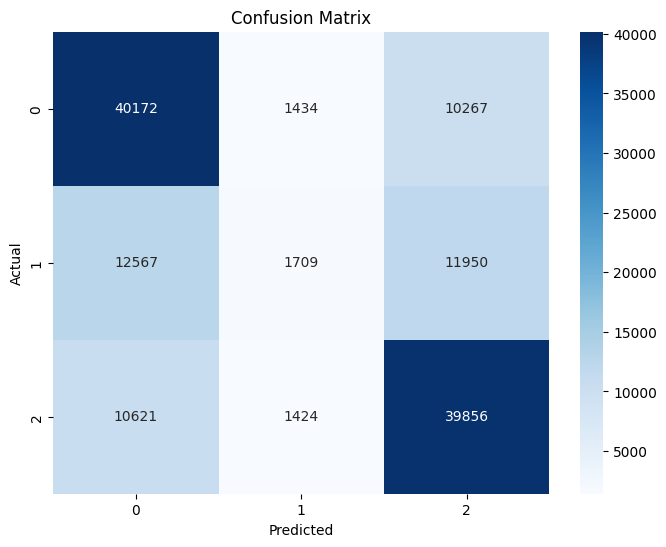

In [26]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Create a function for sentiment prediction

In [29]:
def predict_sentiment(text, word2vec_model, clf):
    processed_text = preprocess_text(text)
    embedding = get_document_embedding(processed_text, word2vec_model)
    prediction = clf.predict([embedding])[0]
    return prediction


# Example usage
sample_text = "This product is just fine. May be It can be improved more."
result = predict_sentiment(sample_text, loaded_word2vec_model, clf)
print(f"Sentiment: {result}")

Sentiment: -1
